# Preparation

## Load packages and data

In [1]:
import polars as pl
from src.utils import read_gtf, read_gff
from src.single_cell import SingleCell
from src.ryp import r, to_r, set_config
import seaborn as sns
import matplotlib.pyplot as plt

Loading required package: svglite


In [3]:
r(
"""
library(ggpubr)
library(pheatmap)
library(RColorBrewer)
library(stringr)
library(scales)
library(dplyr)
"""
)

Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
r(
"""
colorVector <- c(
  "full-splice_match" = "#009E73",
  "incomplete-splice_match"   = "#0072B2",
  "novel_in_catalog"   = "#D55E00",
  "novel_not_in_catalog"   = "#E69F00",
  "Other" = "#000000"
)

colorVector <- c(
  "Known" = "#009E73",
  "ISM"   = "#0072B2",
  "NIC"   = "#D55E00",
  "NNC"   = "#E69F00",
  "Other" = "#000000"
)
"""
)

In [5]:
r(
"""
colorVector <- c(
  "full-splice_match" = "#009E73",
  "incomplete-splice_match"   = "#0072B2",
  "novel_in_catalog"   = "#D55E00",
  "novel_not_in_catalog"   = "#E69F00",
  "Other" = "#000000"
)

colorVector <- c(
  "pFSM" = "#009E73",
  "pISM"   = "#0072B2",
  "pNIC"   = "#D55E00",
  "pNNC"   = "#E69F00",
  "Other" = "#000000"
)
"""
)

# Hybrid dataset

## Load datasets

In [ ]:
detected_peptides = pl.read_csv("nextflow_results/SFARI_peptides_hybrid.csv")
all_peptides = pl.read_csv("nextflow_results/all_peptides_annotated_hybrid.csv")
genome_gff3_gtf = pl.read_csv("nextflow_results/genome_gff3_gtf_hybrid.csv", ignore_errors=True)
lr_bulk = SingleCell("nextflow_results/pbid_orf_hybrid.h5ad")

## Peptides

In [18]:
detected_peptides = detected_peptides["transcript_id"].unique()
df = all_peptides\
    .with_columns(
        detected = pl.when(
            pl.col("transcript_id").is_in(detected_peptides)
        )\
        .then(pl.lit(True))\
        .otherwise(pl.lit(False))
    )


In [25]:
df.group_by(["novelty", "detected"]).len()\
    .group_by("novelty")\
    .agg(
        pl.col("len") / pl.col("len").sum()
    )\
    .explode("len")\
    .group_by("novelty")\
    .first()

novelty,len
str,f64
"""novel""",0.00836
"""known""",0.126355


- [ ] Subsampling the proteomics datasets based on files (saturation plot)
- [ ] Violinplot of expression of protein isoforms validated and not validated by novel peptides
- [ ] Violinplot of expression of protein isoforms validated and not validated by known peptides

null device 
          1 


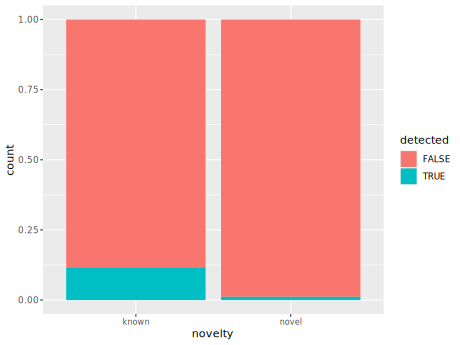

In [15]:
to_r(df, "df")
r(
"""
df %>% 
    ggplot(aes(x=novelty, fill=detected)) +
    stat_count(position=position_fill()) +
    theme(axis.text.x = element_text(size = 8))
"""
)

## Transcript validation by proteomics

### Percentage of protein isoforms that are compatible with any novel peptides

null device 
          1 


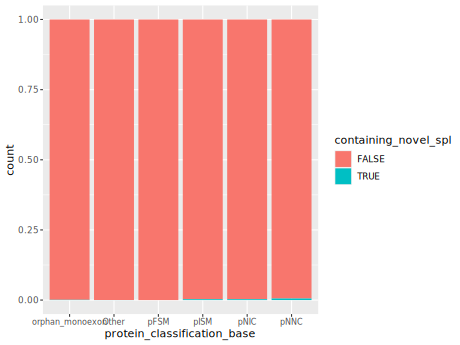

In [27]:
df = genome_gff3_gtf\
    .unique("transcript_id")\
    .drop_nulls("protein_classification_base")\
    .filter(pl.col("protein_classification_base")!="NA")\
    .with_columns(
        protein_classification_base = pl.when(pl.col("protein_classification_base").is_in(["fusion", "antisense", "genic", "intergenic"]))\
            .then(pl.lit("Other"))\
            .otherwise(pl.col("protein_classification_base")),        
    )\
    .filter(pl.col("transcript_id").is_in(lr_bulk.var.unique(["base_isoform"])["base_isoform"]))
to_r(df, "df")
r(
"""
df %>% 
    ggplot(aes(x=protein_classification_base, fill=containing_novel_spl)) +
    stat_count(position=position_fill()) +
    theme(axis.text.x = element_text(size = 8))
"""
)

In [33]:
f"{df.filter( pl.col("containing_novel_spl")).shape[0]} protein isoforms are compatible with at least one novel peptides"

'375 protein isoforms are compatible with at least one novel peptides'

### Percentage of protein isoforms that are compatible with any peptides

#  PacBio isoforms in the protein sequence dataset only

In [6]:
detected_peptides = pl.read_csv("nextflow_results/SFARI_peptides_pacbio.csv")
all_peptides = pl.read_csv("nextflow_results/all_peptides_annotated_pacbio.csv")
genome_gff3_gtf = pl.read_csv("nextflow_results/genome_gff3_gtf_pacbio.csv", ignore_errors=True)
lr_bulk = SingleCell("nextflow_results/pbid_orf_hybrid.h5ad")

In [8]:
genome_gff3_gtf["protein_classification_base"].unique()

protein_classification_base
str
"""pISM"""
"""pFSM"""
"""pNIC"""
"""genic"""
"""fusion"""
"""intergenic"""
"""antisense"""
"""pNNC"""
"""orphan_monoexon"""


In [38]:
genome_gff3_gtf\
    .filter(
        pl.col("containing_novel_spl")
    )\
.unique("transcript_id")\
.group_by("protein_classification_base").len()

protein_classification_base,len
str,u32
"""intergenic""",61
"""pISM""",26
"""pNIC""",57
"""orphan_monoexon""",12
"""pNNC""",390
"""fusion""",4
"""antisense""",3


In [39]:
genome_gff3_gtf\
    .filter(
        pl.col("containing_novel_spl"),
        pl.col("protein_classification_base") == "orphan_monoexon"
    )\
.unique("transcript_id")

,seqname,feature,start,end,strand,gene_name,transcript_id,protein_classification_base,containing_novel_spl
i64,str,str,i64,i64,str,str,str,str,bool
25642,"""chrX""","""CDS""",53940353,53940715,"""-""","""PHF8""","""PB.109102.61""","""orphan_monoexon""",true
517265,"""chr4""","""CDS""",140379575,140379913,"""+""","""SCOC""","""PB.31523.39""","""orphan_monoexon""",true
1418221,"""chr17""","""CDS""",43021540,43022322,"""-""","""VAT1""","""PB.95811.103""","""orphan_monoexon""",true
1594461,"""chr20""","""CDS""",37522639,37523169,"""-""","""NA""","""PB.103669.235""","""orphan_monoexon""",true
145392,"""chr1""","""CDS""",111755462,111755926,"""-""","""NA""","""PB.4028.275""","""orphan_monoexon""",true
…,…,…,…,…,…,…,…,…,…
1498319,"""chr19""","""CDS""",4361723,4362103,"""+""","""NA""","""PB.100526.23""","""orphan_monoexon""",true
283440,"""chr2""","""CDS""",99402232,99402564,"""+""","""NA""","""PB.12530.1223""","""orphan_monoexon""",true
128117,"""chr1""","""CDS""",77044213,77044884,"""+""","""ST6GALNAC5""","""PB.2683.92""","""orphan_monoexon""",true


In [40]:
lr_bulk.var\
    .filter(pl.col("isoform")=="PB.109102.61")


isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,at_least_one_orf,predicted_orf,ORF_type,base_isoform,in_any_PSMs,in_novel_only_PSMs,validated_proteomics
str,enum,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,enum,enum,enum,enum,enum,enum,enum,enum,enum,i64,i64,enum,f64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,bool,enum,enum,bool,bool,bool
"""PB.109102.61""","""chrX""","""-""",4908,2,"""incomplete-splice_match""","""PHF8""","""ENST00000687283.1""",3206,4,20527,-12,2042,-2,"""3prime_fragment""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,53940349,53940715,null,15.0,"""AATTGCTTTGCTTGGCATTC""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.109102.61""",true,true,true


### WASH7P (Pseudogene)

https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr1%3A17324%2D19696&hgsid=2437126059_pUXMutcmZbyePR2GkLceGzRD3aSh

In [16]:
lr_bulk.var\
    .filter(pl.col("isoform")=="PB.6.19")

isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,at_least_one_orf,predicted_orf,ORF_type,base_isoform,in_any_PSMs,in_novel_only_PSMs,validated_proteomics
str,enum,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,enum,enum,enum,enum,enum,enum,enum,enum,enum,i64,i64,enum,f64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,bool,enum,enum,bool,bool,bool
"""PB.6.19""","""chr1""","""-""",1794,11,"""novel_not_in_catalog""","""WASH7P""","""novel""",1351,11,null,null,148,2,"""at_least_one_novel_splicesite""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""B""","""non_coding""",null,null,null,null,24737,17368,null,40.0,"""AACAGTGTGCTTTTAATAAA""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.6.19""",true,true,true


### PDE4DIPP2 (lncRNA)

https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr1%3A120538148%2D120545947&hgsid=2437151929_iA9G2aYIwXgAAdXvVdSZH4opLKqp

In [31]:
lr_bulk.var\
    .filter(pl.col("isoform")=="PB.4353.244")

isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,at_least_one_orf,predicted_orf,ORF_type,base_isoform,in_any_PSMs,in_novel_only_PSMs,validated_proteomics
str,enum,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,enum,enum,enum,enum,enum,enum,enum,enum,enum,i64,i64,enum,f64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,bool,enum,enum,bool,bool,bool
"""PB.4353.244""","""chr1""","""-""",5767,15,"""novel_not_in_catalog""","""PDE4DIPP2""","""novel""",6897,42,null,null,-10533,2,"""at_least_one_novel_splicesite""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""B""","""non_coding""",null,null,null,null,120557018,120542086,null,15.0,"""GTTTTGTGTCCAGATTCTCA""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.4353.244""",true,true,true


### novelGene_ENSG00000226506_AS 

https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A7857892%2D7896771&hgsid=2437126059_pUXMutcmZbyePR2GkLceGzRD3aSh

In [32]:
lr_bulk.var\
    .filter(pl.col("isoform")=="PB.8928.42")


isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,at_least_one_orf,predicted_orf,ORF_type,base_isoform,in_any_PSMs,in_novel_only_PSMs,validated_proteomics
str,enum,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,enum,enum,enum,enum,enum,enum,enum,enum,enum,i64,i64,enum,f64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,bool,enum,enum,bool,bool,bool
"""PB.8928.42""","""chr2""","""+""",2115,2,"""antisense""","""novelGene_ENSG00000226506_AS""","""novel""",null,null,null,null,null,null,"""multi-exon""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""B""","""non_coding""",null,null,null,null,7877115,7877550,null,25.0,"""TTGTTGTATTATTCTTAAAT""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.8928.40""",false,false,false


### ZNF783 (protein coding)

https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A149284285%2D149305974&hgsid=2437126059_pUXMutcmZbyePR2GkLceGzRD3aSh

In [34]:
lr_bulk.var\
    .filter(pl.col("isoform")=="PB.53680.442")


isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,at_least_one_orf,predicted_orf,ORF_type,base_isoform,in_any_PSMs,in_novel_only_PSMs,validated_proteomics
str,enum,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,enum,enum,enum,enum,enum,enum,enum,enum,enum,i64,i64,enum,f64,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,bool,bool,enum,enum,bool,bool,bool
"""PB.53680.442""","""chr7""","""+""",3786,5,"""novel_in_catalog""","""ENSG00000244560""","""novel""",2804,10,null,null,-22,-1,"""intron_retention""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,149294768,149295494,null,30.0,"""ATGCCATTCTCAATTTTAAT""",null,null,null,null,null,null,null,null,null,null,null,true,true,"""complete""","""PB.53680.418""",false,false,false


## Peptides

In [35]:
detected_peptides = detected_peptides["transcript_id"].unique()
df = all_peptides\
    .with_columns(
        detected = pl.when(
            pl.col("transcript_id").is_in(detected_peptides)
        )\
        .then(pl.lit(True))\
        .otherwise(pl.lit(False))
    )


In [36]:
df.group_by(["novelty", "detected"]).len()

novelty,detected,len
str,bool,u32
"""known""",true,103174
"""novel""",true,480
"""known""",false,713365
"""novel""",false,56935


In [42]:
f"Using the PacBio database, {480/(480+56935)*100}% of the novel peptides are detected"

'Using the PacBio database, 0.8360184620743708% of the novel peptides are detected'

In [43]:
f"Using the PacBio database, {103174/(103174+713365)*100}% of all peptides are detected"

'Using the PacBio database, 12.635526288395289% of all peptides are detected'

null device 
          1 


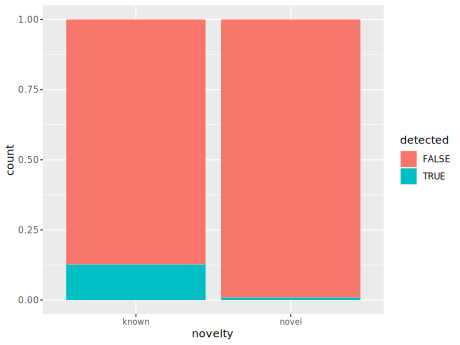

In [41]:
to_r(df, "df")
r(
"""
df %>% 
    ggplot(aes(x=novelty, fill=detected)) +
    stat_count(position=position_fill()) +
    theme(axis.text.x = element_text(size = 8))
"""
)

## Transcript validation by proteomics

### Percentage of protein isoforms that are compatible with any novel peptides

null device 


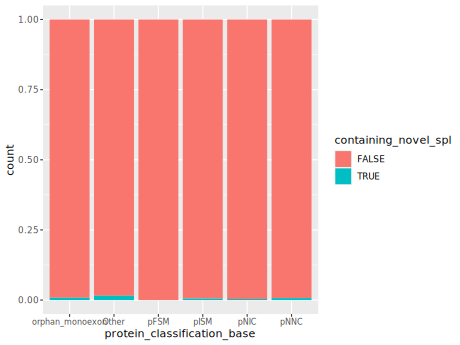

          1 


In [62]:
df = genome_gff3_gtf\
    .unique("transcript_id")\
    .drop_nulls("protein_classification_base")\
    .filter(pl.col("protein_classification_base")!="NA")\
    .with_columns(
        protein_classification_base = pl.when(pl.col("protein_classification_base").is_in(["fusion", "antisense", "genic", "intergenic"]))\
            .then(pl.lit("Other"))\
            .otherwise(pl.col("protein_classification_base")),        
    )\
    .filter(pl.col("transcript_id").is_in(lr_bulk.filter_var(pl.col("ORF_type")=="complete").var.unique(["base_isoform"])["base_isoform"]))
to_r(df, "df")
r(
"""
df %>% 
    ggplot(aes(x=protein_classification_base, fill=containing_novel_spl)) +
    stat_count(position=position_fill()) +
    theme(axis.text.x = element_text(size = 8))
"""
)

In [1]:
genome_gff3_gtf

NameError: name 'genome_gff3_gtf' is not defined

In [72]:
df.group_by(["protein_classification_base", "containing_novel_spl"]).len().write_csv("test.csv")

In [45]:
f"{df.filter( pl.col("containing_novel_spl")).shape[0]} protein isoforms are compatible with at least one novel peptides"

'418 protein isoforms are compatible with at least one novel peptides'

# Other

## pr_splice_cat

/tmp/ipykernel_90900/2091807584.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))\


null device 
          1 


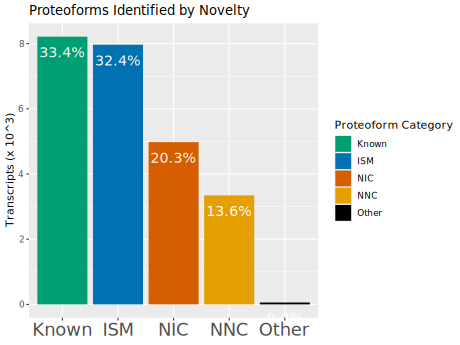

In [65]:
df = lr_bulk.var\
    .with_columns(
        pl.col("base_isoform").cast(pl.String)
    )\
    .filter(
        pl.col("isoform") == pl.col("base_isoform"),
        pl.col("ORF_type") == "complete",
        pl.col("validated_proteomics")
    )\
    .group_by("pr_splice_cat2")\
    .agg(pl.count().alias("count"))\
    .with_columns(
        (pl.col("count") / pl.col("count").sum() * 100).alias("percentage")
    )

to_r(df, "df")
r(
"""
df$pr_splice_cat2 <- factor(df$pr_splice_cat2, levels = c("Known", "ISM", "NIC", "NNC", "Other"))

df %>% 
    ggplot(aes(x = pr_splice_cat2, y = count, fill = pr_splice_cat2)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = 2, colour = "white", size = 5) +
    theme(axis.text.x = element_text(size = 18)) +
    labs(x = "Proteoform Category", y = "Percentage", title = "Proteoforms Identified by Novelty") +
    scale_fill_manual("Proteoform Category", values=colorVector) +
    scale_y_continuous(labels = function(x) x/1000) +
    ylab("Transcripts (x 10^3)") +
    xlab(NULL)
"""
)

/tmp/ipykernel_90900/3052553393.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))\


null device 
          1 


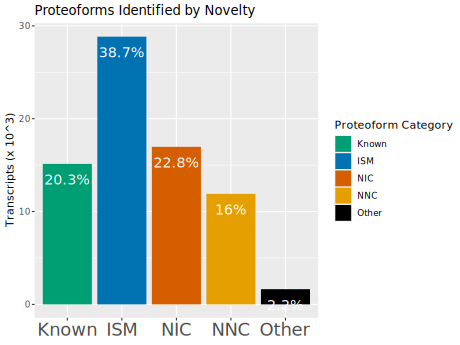

In [66]:
df = lr_bulk.var\
    .with_columns(
        pl.col("base_isoform").cast(pl.String)
    )\
    .filter(
        pl.col("isoform") == pl.col("base_isoform"),
        pl.col("ORF_type") == "complete"
    )\
    .group_by("pr_splice_cat2")\
    .agg(pl.count().alias("count"))\
    .with_columns(
        (pl.col("count") / pl.col("count").sum() * 100).alias("percentage")
    )

to_r(df, "df")
r(
"""
df$pr_splice_cat2 <- factor(df$pr_splice_cat2, levels = c("Known", "ISM", "NIC", "NNC", "Other"))

df %>% 
    ggplot(aes(x = pr_splice_cat2, y = count, fill = pr_splice_cat2)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = 2, colour = "white", size = 5) +
    theme(axis.text.x = element_text(size = 18)) +
    labs(x = "Proteoform Category", y = "Percentage", title = "Proteoforms Identified by Novelty") +
    scale_fill_manual("Proteoform Category", values=colorVector) +
    scale_y_continuous(labels = function(x) x/1000) +
    ylab("Transcripts (x 10^3)") +
    xlab(NULL)
"""
)

null device 
          1 


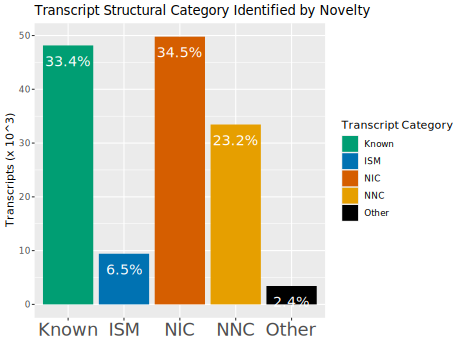

In [48]:
df = lr_bulk.var\
    .filter(pl.col("ORF_type")=="complete")\
    .with_columns(
        structural_category2 = pl.col("structural_category2").replace_strict(structural_category_labels)
    )\
    .group_by("structural_category2")\
    .agg(pl.len().alias("len"))\
    .with_columns(
        (pl.col("len") / pl.col("len").sum() * 100).alias("percentage")
    )
to_r(df, "df")
r(
"""
df$structural_category2 <- factor(df$structural_category2, levels = c("Known", "ISM", "NIC", "NNC", "Other"))

df %>% 
    ggplot(aes(x = structural_category2, y = len, fill = structural_category2)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = 2, colour = "white", size = 5) +
    theme(axis.text.x = element_text(size = 18)) +
    labs(x = "Transcript Structural Category", y = "Percentage", title = "Transcript Structural Category Identified by Novelty") +
    scale_fill_manual("Transcript Category", values=colorVector) +
    scale_y_continuous(labels = function(x) x/1000) +
    ylab("Transcripts (x 10^3)") +
    xlab(NULL)
"""
)


null device 
          1 


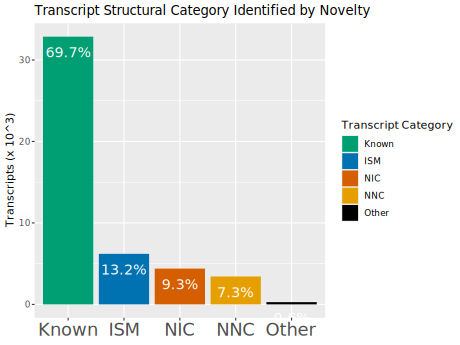

In [63]:
df = lr_bulk.var\
    .filter(
        pl.col("ORF_type")=="complete",
        pl.col("validated_proteomics")
        )\
    .with_columns(
        structural_category2 = pl.col("structural_category2").replace_strict(structural_category_labels)
    )\
    .group_by("structural_category2")\
    .agg(pl.len().alias("len"))\
    .with_columns(
        (pl.col("len") / pl.col("len").sum() * 100).alias("percentage")
    )
to_r(df, "df")
r(
"""
df$structural_category2 <- factor(df$structural_category2, levels = c("Known", "ISM", "NIC", "NNC", "Other"))

df %>% 
    ggplot(aes(x = structural_category2, y = len, fill = structural_category2)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = 2, colour = "white", size = 5) +
    theme(axis.text.x = element_text(size = 18)) +
    labs(x = "Transcript Structural Category", y = "Percentage", title = "Transcript Structural Category Identified by Novelty") +
    scale_fill_manual("Transcript Category", values=colorVector) +
    scale_y_continuous(labels = function(x) x/1000) +
    ylab("Transcripts (x 10^3)") +
    xlab(NULL)
"""
)


## protein_classification_base

In [56]:
structural_category_labels = {"full-splice_match": "Known", "incomplete-splice_match": "ISM", "novel_in_catalog": "NIC", "novel_not_in_catalog": "NNC", "Other": "Other"}
lr_bulk = SingleCell("nextflow_results/pbid_orf_hybrid.h5ad")
protein_classification = pl.read_csv("nextflow_results/SFARI_unfiltered.protein_classification.tsv", separator = "\t")
lr_bulk = lr_bulk\
    .with_columns_var(
        base_isoform = pl.col("base_isoform").cast(pl.String)
    )\
    .filter_var(
        pl.col("base_isoform") == pl.col("isoform"),
        pl.col("ORF_type") == "complete"
    )
lr_bulk.var = lr_bulk.var\
    .join(
        protein_classification["pb", "protein_classification_base"].rename({"pb": "isoform"}), 
        on = "isoform", 
        how = "left"
    )\
    .with_columns(
        pl.col("structural_category").cast(pl.String)
    )\
    .with_columns(
        protein_classification_base2 = pl.when(pl.col("protein_classification_base").is_in(["fusion", "antisense", "genic", "intergenic", "orphan_monoexon"]))\
            .then(pl.lit("Other"))\
            .otherwise(pl.col("protein_classification_base")),
        structural_category2 = pl.when(pl.col("structural_category").is_in(["fusion", "antisense", "genic", "intergenic", "moreJunctions"]))\
            .then(pl.lit("Other"))\
            .otherwise(pl.col("structural_category"))
    )

/tmp/ipykernel_218392/2148886444.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))\


null device 
          1 


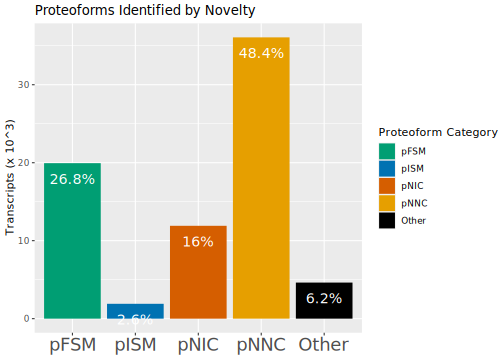

In [64]:
set_config(plot_width = 7, plot_height = 5)
df = lr_bulk.var\
    .drop_nulls("protein_classification_base2")\
    .group_by("protein_classification_base2")\
    .agg(pl.count().alias("count"))\
    .with_columns(
        (pl.col("count") / pl.col("count").sum() * 100).alias("percentage")
    )

to_r(df, "df")
r(
"""
df$protein_classification_base2 <- factor(df$protein_classification_base2, levels = c("pFSM", "pISM", "pNIC", "pNNC", "Other"))

df %>% 
    ggplot(aes(x = protein_classification_base2, y = count, fill = protein_classification_base2)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = 2, colour = "white", size = 5) +
    theme(axis.text.x = element_text(size = 18)) +
    labs(x = "Proteoform Category", y = "Percentage", title = "Proteoforms Identified by Novelty") +
    scale_fill_manual("Proteoform Category", values=colorVector) +
    scale_y_continuous(labels = function(x) x/1000) +
    ylab("Transcripts (x 10^3)") +
    xlab(NULL)
"""
)

# Fix sqanti3_protein.py

In [27]:
lr_bulk = SingleCell("nextflow_results/pbid_orf_hybrid.h5ad")
lr_bulk = lr_bulk.filter_var(pl.col("ORF_type")=="complete")
# protein_classification = pl.read_csv("nextflow_results/SFARI_unfiltered.protein_classification.tsv", separator = "\t")
protein_classification = pl.read_csv("/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/work/d1/a1deb4128d4da133378ef227d68bce/SFARI.sqanti_protein_classification.tsv", separator = "\t")
lr_bulk.var = lr_bulk.var\
    .join(
        protein_classification["pb", "pr_splice_cat", "protein_classification_base", "protein_classification_subset"].rename({"pb": "isoform"}), 
        on = "isoform", 
        how = "left"
    )

ComputeError: could not parse `NA` as dtype `i64` at column 'tx_tss_gene_diff' (column number 8)

The current offset in the file is 14736486 bytes.

You might want to try:
- increasing `infer_schema_length` (e.g. `infer_schema_length=10000`),
- specifying correct dtype with the `dtypes` argument
- setting `ignore_errors` to `True`,
- adding `NA` to the `null_values` list.

Original error: ```remaining bytes non-empty```

In [28]:
sample_cds = read_gtf("nextflow_results/transcripts_filtered.fasta.transdecoder.genome.gff3.gtf").filter(pl.col("feature")=="CDS")
gencode_cds =read_gtf("/project/s/shreejoy/Genomic_references/GENCODE/gencode.v39.annotation.gtf").filter(pl.col("feature")=="CDS")

In [32]:
sample_cds.filter(pl.col("transcript_id")=="PB.112403.21")

seqname,source,feature,start,end,score,strand,frame,attributes,transcript_id
str,str,str,i64,i64,str,str,str,str,str
"""chrY""","""transdecoder""","""CDS""",2841944,2841973,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""
"""chrY""","""transdecoder""","""CDS""",2842165,2842242,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""
"""chrY""","""transdecoder""","""CDS""",2844077,2844257,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""
"""chrY""","""transdecoder""","""CDS""",2845646,2845743,""".""","""+""","""2""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""
"""chrY""","""transdecoder""","""CDS""",2854600,2854771,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""
"""chrY""","""transdecoder""","""CDS""",2865088,2865245,""".""","""+""","""2""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""
"""chrY""","""transdecoder""","""CDS""",2866793,2866891,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.21"""


In [34]:
gencode_cds.filter(pl.col("transcript_id")=="ENST00000430575.1")

seqname,source,feature,start,end,score,strand,frame,attributes,transcript_id
str,str,str,i64,i64,str,str,str,str,str
"""chrY""","""HAVANA""","""CDS""",2841944,2841973,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""
"""chrY""","""HAVANA""","""CDS""",2842165,2842242,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""
"""chrY""","""HAVANA""","""CDS""",2844077,2844257,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""
"""chrY""","""HAVANA""","""CDS""",2845646,2845743,""".""","""+""","""2""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""
"""chrY""","""HAVANA""","""CDS""",2854600,2854771,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""
"""chrY""","""HAVANA""","""CDS""",2865088,2865245,""".""","""+""","""2""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""
"""chrY""","""HAVANA""","""CDS""",2866793,2866862,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000430575.1"""


In [35]:
2866891 - 2866862

29

In [25]:
lr_bulk.var\
    .with_columns(
        base_isoform = pl.col("base_isoform").cast(pl.String)
    )\
    .filter(
        pl.col("protein_classification_base") == "pNNC",
        pl.col("structural_category") == "full-splice_match",
        pl.col("base_isoform") == pl.col("isoform")
    )["isoform"].to_frame().write_csv("pbids_to_be_tested.csv")

In [ ]:
apptainer shell -B /gpfs/fs0/scratch/s/shreejoy/nxu/SFARI $NXF_SINGULARITY_CACHEDIR/sqanti_protein.sif
cd /gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/work/d1/a1deb4128d4da133378ef227d68bce
sqanti3_protein.py \
    SFARI.transcript_exons_only.gtf \
    SFARI.cds_renamed_exon.gtf \
    best_orf.tsv \
    gencode.transcript_exons_only.gtf \
    gencode.cds_renamed_exon.gtf \
    -d ./ \
    -p SFARI

In [6]:
protein_classification.filter(pl.col("pb")=="PB.112403.1")

pb,tx_cat,pr_splice_cat,tx_subcat,pr_splice_subcat,tx_tss_diff,tx_tts_diff,tx_tss_gene_diff,tx_tts_gene_diff,pr_nterm_diff,pr_cterm_diff,pr_nterm_gene_diff,pr_cterm_gene_diff,tx_transcripts,pr_transcripts,tx_gene,pr_gene,tx_num_exons,pr_num_exons,is_nmd,num_junc_after_stop_codon,num_nt_after_stop_codon,tx_5hang,tx_3hang,pr_nhang,pr_chang
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64
"""PB.112403.1""","""full-splice_match""","""full-splice_match""","""multi-exon""","""multi-exon""","""-212""","""-62""","""-212""","""62""","""23""","""377""","""23""","""29""","""ENST00000250784.13""","""ENST00000250784.13""","""ENSG00000129824.16""","""ENSG00000129824.16""",7,7,"""FALSE""",0,271,212,62,-23,-377


In [38]:
sample_cds.filter(pl.col("transcript_id")=="PB.112403.1")

seqname,source,feature,start,end,score,strand,frame,attributes,transcript_id
str,str,str,i64,i64,str,str,str,str,str
"""chrY""","""transdecoder""","""CDS""",2841625,2841627,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""
"""chrY""","""transdecoder""","""CDS""",2842165,2842242,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""
"""chrY""","""transdecoder""","""CDS""",2844077,2844257,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""
"""chrY""","""transdecoder""","""CDS""",2845646,2845743,""".""","""+""","""2""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""
"""chrY""","""transdecoder""","""CDS""",2854600,2854771,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""
"""chrY""","""transdecoder""","""CDS""",2865088,2865245,""".""","""+""","""2""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""
"""chrY""","""transdecoder""","""CDS""",2866793,2866891,""".""","""+""","""0""","""gene_id ""PB.112403""; transcrip…","""PB.112403.1"""


In [39]:
gencode_cds.filter(pl.col("transcript_id")=="ENST00000250784.13")

seqname,source,feature,start,end,score,strand,frame,attributes,transcript_id
str,str,str,i64,i64,str,str,str,str,str
"""chrY""","""HAVANA""","""CDS""",2841625,2841627,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""
"""chrY""","""HAVANA""","""CDS""",2842165,2842242,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""
"""chrY""","""HAVANA""","""CDS""",2844077,2844257,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""
"""chrY""","""HAVANA""","""CDS""",2845646,2845743,""".""","""+""","""2""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""
"""chrY""","""HAVANA""","""CDS""",2854600,2854771,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""
"""chrY""","""HAVANA""","""CDS""",2865088,2865245,""".""","""+""","""2""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""
"""chrY""","""HAVANA""","""CDS""",2866793,2866891,""".""","""+""","""0""","""gene_id ""ENSG00000129824.16""; …","""ENST00000250784.13"""


# Add peptide support

In [60]:
percolator = pl.read_csv("nextflow_results/hybrid_percolator.tsv", has_header=True, separator="\t")
percolator = percolator\
    .with_columns(
    proteinIds = percolator["proteinIds"].map_elements(lambda s: s.split(","))
    ).explode("proteinIds")\
    .filter(
        pl.col("q-value") < 0.05
    )
percolator_pbid = percolator\
    .filter(pl.col("proteinIds").str.starts_with("PB"))

percolator_ENST = percolator\
    .filter(pl.col("proteinIds").str.starts_with("ENSP"))

percolator_ENST = percolator_ENST.with_columns(pl.col("proteinIds").str.split("|").map_elements(lambda s: s[1], return_dtype=pl.String))
percolator = pl.concat([percolator_pbid, percolator_ENST], how="vertical")

/tmp/ipykernel_90900/2481585650.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  proteinIds = percolator["proteinIds"].map_elements(lambda s: s.split(","))


In [62]:
PSMId_mapped_to_novel_transcripts_uniquely = percolator\
    .with_columns(
        is_known = pl.col("proteinIds").str.starts_with("ENST").cast(pl.Boolean)
        )\
    .group_by("PSMId")\
    .agg(
        pl.col("is_known").sum()
    )\
    .filter(
        pl.col("is_known")==0
    )\
    .select("PSMId")

validated_pbids = percolator\
    .filter(
        pl.col("PSMId").is_in(PSMId_mapped_to_novel_transcripts_uniquely)
    )\
    .select("proteinIds").unique()

lr_bulk.var = lr_bulk.var\
    .with_columns(
        in_any_PSMs = pl.col("associated_transcript").is_in(percolator["proteinIds"].unique()) | pl.col("isoform").is_in(percolator["proteinIds"].unique()),
        in_novel_only_PSMs = pl.col("isoform").is_in(validated_pbids)
    )\
    .with_columns(
        validated_proteomics = pl.when(pl.col("structural_category").is_in(["novel_not_in_catalog", "novel_in_catalog"]))\
            .then(pl.col("in_novel_only_PSMs")).otherwise(pl.col("in_any_PSMs"))
    )

/tmp/ipykernel_190858/1932673567.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


[Text(0, 0, 'full-splice_match'),
 Text(1, 0, 'incomplete-splice_match'),
 Text(2, 0, 'novel_in_catalog'),
 Text(3, 0, 'novel_not_in_catalog'),
 Text(4, 0, 'Other')]

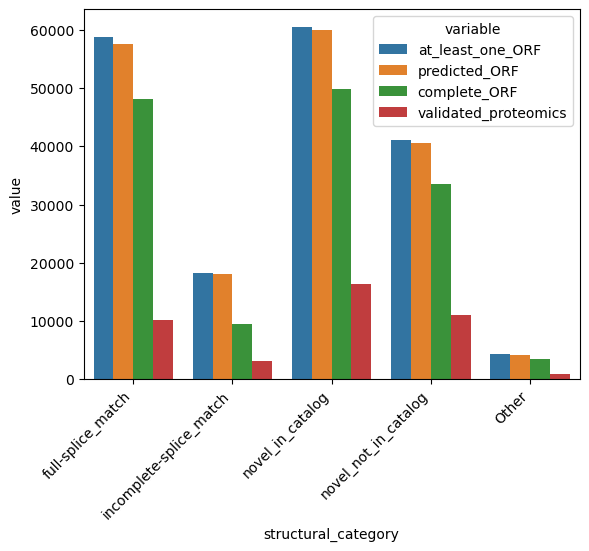

In [46]:
lr_bulk.var = lr_bulk.var\
    .with_columns(
        pl.col("structural_category").cast(pl.String)
    )\
    .with_columns(
        pl.when(pl.col("structural_category").is_in(["novel_not_in_catalog", "novel_in_catalog", "full-splice_match", "incomplete-splice_match"]))\
            .then(pl.col("structural_category"))\
            .otherwise(pl.lit("Other"))
    )
temp = lr_bulk.var\
    .with_columns(
        pl.when(pl.col("ORF_type")=="complete").then(pl.lit(True)).otherwise(pl.lit(False)).alias("complete_ORF")
    ).drop("ORF_type")\
    .group_by("structural_category")\
    .agg(
        at_least_one_ORF = pl.col("at_least_one_orf").sum(),
        predicted_ORF = pl.col("predicted_orf").sum(),
        complete_ORF = pl.col("complete_ORF").sum(),
        validated_proteomics = pl.col("validated_proteomics").sum()
    )\
    .unpivot(index="structural_category")\
    .with_columns(
        pl.col("structural_category").cast(pl.Enum(["full-splice_match", "incomplete-splice_match", "novel_in_catalog", "novel_not_in_catalog", "Other"]))
    )
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(data=temp.to_pandas(), x="structural_category", y="value", hue="variable", ax =ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [9]:
lr_bulk.var\
    .filter(
        pl.col("structural_category") == "full-splice_match",
        pl.col("protein_classification_base") == "pNNC"
    )["isoform", "structural_category", "associated_gene", "protein_classification_base", "associated_transcript", "protein_classification_subset"]

isoform,structural_category,associated_gene,protein_classification_base,associated_transcript,protein_classification_subset
str,enum,enum,str,enum,str
"""PB.6.390""","""full-splice_match""","""ENSG00000238009""","""pNNC""","""ENST00000453576.2""","""novel_nterm_known_splice_novel…"
"""PB.15.8""","""full-splice_match""","""NOC2L""","""pNNC""","""ENST00000327044.7""","""novel_nterm_known_splice_novel…"
"""PB.15.514""","""full-splice_match""","""NOC2L""","""pNNC""","""ENST00000469563.1""","""novel_nterm_known_splice_novel…"
"""PB.19.3""","""full-splice_match""","""HES4""","""pNNC""","""ENST00000484667.2""","""novel_nterm_known_splice_novel…"
"""PB.19.4""","""full-splice_match""","""HES4""","""pNNC""","""ENST00000304952.11""","""novel_nterm_known_splice_novel…"
…,…,…,…,…,…
"""PB.112762.203""","""full-splice_match""","""KDM5D""","""pNNC""","""ENST00000382806.6""","""known_nterm_known_splice_novel…"
"""PB.112762.206""","""full-splice_match""","""KDM5D""","""pNNC""","""ENST00000317961.9""","""novel_nterm_known_splice_novel…"
"""PB.112777.1""","""full-splice_match""","""EIF1AY""","""pNNC""","""ENST00000361365.7""","""novel_nterm_known_splice_novel…"


In [7]:
from src.utils import read_gtf
sample_gtf = read_gtf("nextflow_results/transcripts_filtered.fasta.transdecoder.genome.gff3.gtf")

In [8]:
sample_gtf.filter(pl.col("transcript_id") == "PB.15.8").write_csv("test.csv")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

## Define functions

# Start here

## Annotate lr_bulk with peptide support

In [4]:
percolator_res = pl.read_csv("nextflow_results/percolator.tsv", has_header=True, separator="\t")

In [8]:
percolator_res = percolator_res\
    .with_columns(
       proteinIds = pl.col("proteinIds").map_elements(lambda s: s.split(","), return_dtype=pl.List(pl.String))
   )\
   .explode("proteinIds")\
   .filter(
        pl.col("q-value") < 0.05
    )

In [10]:
percolator_res

PSMId,score,q-value,posterior_error_prob,peptide,proteinIds
str,f64,f64,f64,str,str
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.1336"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.287"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.293"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.295"""
"""file7_4078_3_1""",2.12649,0.000056,1.9562e-13,"""R.QHGEQLGGGGSGGGGYNNSK.H""","""PB.1039.296"""
…,…,…,…,…,…
"""file1_34096_2_3""",-0.109295,0.0499947,0.514237,"""K.ELNILK.S""","""ENSP00000496653.1|ENST00000645…"
"""file1_34096_2_3""",-0.109295,0.0499947,0.514237,"""K.ELNILK.S""","""ENSP00000494610.1|ENST00000646…"
"""file1_34096_2_3""",-0.109295,0.0499947,0.514237,"""K.ELNILK.S""","""ENSP00000292538.4|ENST00000292…"


In [15]:
ENST = percolator_res\
    .filter(
        pl.col("proteinIds").str.starts_with("ENSP")
    )\
    .with_columns(
        proteinIds = pl.col("proteinIds").str.split("|").map_elements(lambda x: x[1])
    )
PB_ID = percolator_res\
    .filter(
        pl.col("proteinIds").str.starts_with("PB")
    )

percolator_res = pl.concat([ENST, PB_ID], how="vertical")

/tmp/ipykernel_91289/3302576709.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


In [16]:
PSMId_mapped_to_novel_transcripts_uniquely = percolator_res\
    .with_columns(
        is_known = pl.col("proteinIds").str.starts_with("ENST")
    )\
    .group_by("PSMId")\
    .agg(
        pl.col("is_known").sum()
    )\
    .filter(
        pl.col("is_known")==0
    )\
    .select("PSMId")

In [17]:
validated_pbids = percolator_res\
    .filter(
        pl.col("PSMId").is_in(PSMId_mapped_to_novel_transcripts_uniquely)
    )\
    .select("proteinIds").unique()

In [18]:
lr_bulk.var = lr_bulk.var\
    .with_columns(
        in_any_PSMs = pl.col("associated_transcript").is_in(percolator_res["proteinIds"].unique()) | pl.col("isoform").is_in(percolator_res["proteinIds"].unique()),
        in_novel_only_PSMs = pl.col("isoform").is_in(validated_pbids)
    )\
    .with_columns(
        validated_proteomics = pl.when(pl.col("structural_category").is_in(["novel_not_in_catalog", "novel_in_catalog"]))\
            .then(pl.col("in_novel_only_PSMs")).otherwise(pl.col("in_any_PSMs"))
    )


## GenomeKit

In [4]:
genome = gk.Genome("SFARI")

In [10]:
base_isoform = lr_bulk.var\
    .filter(
        pl.col("base_isoform").is_null().not_(),
        pl.col("ORF_type")=="complete"
        )\
    .group_by("base_isoform")\
    .agg(
        pl.col("isoform"),
        pl.col("structural_category")
    )\
    .with_columns(
        pl.col("structural_category").map_elements(lambda x: x.unique())
    )\
    .with_columns(
        n_structural_category = pl.col("structural_category").map_elements(lambda x : len(x))
    )\
    .rename({"structural_category": "structural_category_list"})

/tmp/ipykernel_125142/3978943237.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(
/tmp/ipykernel_125142/3978943237.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  base_isoform = lr_bulk.var\


In [29]:
base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]

/tmp/ipykernel_125142/4065386927.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]


25007

In [28]:
base_isoform\
    .filter(
        pl.col("isoform").map_elements(lambda x :len(x)>1)
    )\
    .group_by("n_structural_category")\
    .len()\
    .with_columns(
        percentage = (pl.col("len") / base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]) * 100
    )

/tmp/ipykernel_125142/343316249.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .filter(
/tmp/ipykernel_125142/343316249.py:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  percentage = (pl.col("len") / base_isoform.filter(pl.col("isoform").map_elements(lambda x :len(x)>1)).shape[0]) * 100


n_structural_category,len,percentage
i64,u32,f64
4,345,1.379614
5,21,0.083976
3,2092,8.365658
1,14776,59.087456
2,7773,31.083297


## Visualization

/tmp/ipykernel_91289/1932673567.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


[Text(0, 0, 'full-splice_match'),
 Text(1, 0, 'incomplete-splice_match'),
 Text(2, 0, 'novel_in_catalog'),
 Text(3, 0, 'novel_not_in_catalog'),
 Text(4, 0, 'Other')]

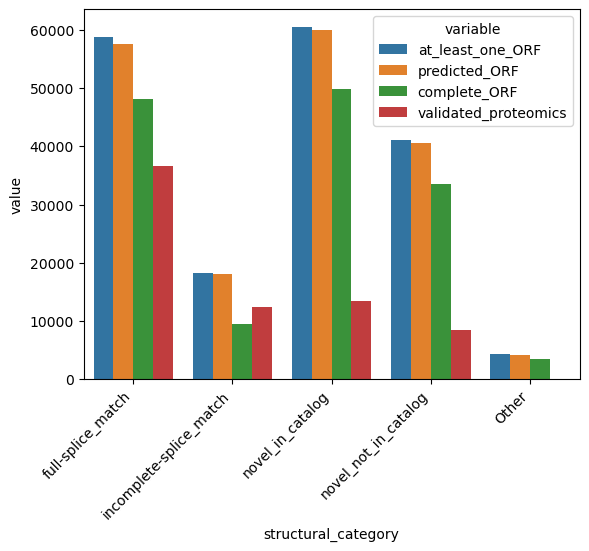

In [19]:
lr_bulk.var = lr_bulk.var\
    .with_columns(
        pl.col("structural_category").cast(pl.String)
    )\
    .with_columns(
        pl.when(pl.col("structural_category").is_in(["novel_not_in_catalog", "novel_in_catalog", "full-splice_match", "incomplete-splice_match"]))\
            .then(pl.col("structural_category"))\
            .otherwise(pl.lit("Other"))
    )
temp = lr_bulk.var\
    .with_columns(
        pl.when(pl.col("ORF_type")=="complete").then(pl.lit(True)).otherwise(pl.lit(False)).alias("complete_ORF")
    ).drop("ORF_type")\
    .group_by("structural_category")\
    .agg(
        at_least_one_ORF = pl.col("at_least_one_orf").sum(),
        predicted_ORF = pl.col("predicted_orf").sum(),
        complete_ORF = pl.col("complete_ORF").sum(),
        validated_proteomics = pl.col("validated_proteomics").sum()
    )\
    .unpivot(index="structural_category")\
    .with_columns(
        pl.col("structural_category").cast(pl.Enum(["full-splice_match", "incomplete-splice_match", "novel_in_catalog", "novel_not_in_catalog", "Other"]))
    )
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(data=temp.to_pandas(), x="structural_category", y="value", hue="variable", ax =ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

## Lengths don't match in PacBio files

In [ ]:
def compare_sequence_len(fasta_tab_file, gtf_file):
    fasta = pl.read_csv(fasta_tab_file, separator = "\t", has_header=False, new_columns=["pbid", "sequence", "null", "len"])["pbid", "len"]
    fasta = fasta\
        .with_columns(
            pl.col("pbid").str.split("|").map_elements(lambda x: x[0], return_dtype=pl.String)
        )
    gtf = read_gtf(gtf_file)
    gtf_len = gtf\
        .filter(
            pl.col("feature") == "exon"
        )\
        .with_columns(
            diff = pl.col("end") - pl.col("start") + 1
        )\
        .group_by("transcript_id")\
        .agg(
            pl.col("diff").sum()
        )
    return fasta\
        .join(
            gtf_len.rename({"transcript_id": "pbid"}),
            how = "left",
            on = "pbid"
        )

In [11]:
compare_sequence_len("proc/merged_collapsed.fasta.tab", "proc/merged_collapsed.gff")

pbid,len,diff
str,i64,i64
"""PB.1.1""",2810,2809
"""PB.1.2""",1680,1678
"""PB.1.3""",2499,2498
"""PB.1.4""",2113,2111
"""PB.1.5""",3359,3360
…,…,…
"""PB.113109.1""",1831,1837
"""PB.113110.1""",723,726
"""PB.113111.1""",1264,1264


In [50]:
compare_sequence_len("/scratch/s/shreejoy/nxu/SFARI/work/c5/65ddff00571c118620e9321f40211d/transcripts.fasta.tab", "/scratch/s/shreejoy/nxu/SFARI/work/c5/65ddff00571c118620e9321f40211d/merged_collapsed.sorted.filtered_lite.gff")

pbid,len,diff
str,i64,i64
"""PB.6.9""",3984,3984
"""PB.6.8""",2646,2646
"""PB.6.10""",2339,2339
"""PB.6.14""",1898,1898
"""PB.6.2""",1658,1658
…,…,…
"""PB.112873.1193""",4436,4436
"""PB.112873.1196""",3680,3680
"""PB.112873.1199""",2482,2482


In [17]:
TD_genome_gff3 = read_gff("nextflow_results/transcripts_filtered.fasta.transdecoder.genome.gff3", attributes=["ID", "Parent"]).drop_nulls("seqname")\
    .with_columns(
        pl.col("feature").replace({"gene": "gene", "five_prime_UTR": "five_prime_UTR", "exon": "exon", "mRNA": "transcript", "CDS": "CDS", "three_prime_UTR": "three_prime_UTR"})
    )\
    .with_columns(
        pl.when(pl.col("feature")=="gene")\
            .then(pl.col("ID").str.split("^").map_elements(lambda x: x[0], return_dtype=pl.String))\
            .when(pl.col("feature")=="transcript")\
            .then(pl.col("ID").str.extract(r"^(.*)\.p\d+$"))\
            .otherwise(pl.col("ID")),
        pl.when(pl.col("feature")=="transcript")\
            .then(pl.col("Parent").str.extract(r"^(.*)\^chr"))\
            .when(pl.col("feature").is_in(["three_prime_UTR", "five_prime_UTR", "CDS", "exon"]))\
            .then(pl.col("Parent").str.extract(r"^(.*)\.p\d+$"))\
            .otherwise(pl.col("Parent"))
    )\
    .with_columns(
        gene_id = pl.when(pl.col("feature")=="gene")\
        .then(pl.col("ID"))\
        .when(pl.col("feature")=="transcript")\
        .then(pl.col("Parent"))\
        .otherwise(pl.col("Parent").str.split(".").map_elements(lambda x: ".".join([x[0], x[1]]), return_dtype=pl.String)),

        transcript_id = pl.when(pl.col("feature")=="gene")\
        .then(pl.lit(None))\
        .when(pl.col("feature")=="transcript")\
        .then(pl.col("ID"))\
        .otherwise(pl.col("Parent"))
    )

In [32]:
!cat /scratch/s/shreejoy/nxu/SFARI/work/d8/8eea1df17bff6a68d4805cd1a50cce/.command.log




	Done.  180238 / 180238 transcript orfs could be propagated to the genome


scontrol show job 13974842
JobId=13974842 JobName=nf-cdnaAlignmentOrfToGenome
   UserId=nxu(3122125) GroupId=shreejoy(6036412) MCS_label=N/A
   Priority=2324467 Nice=0 Account=rrg-shreejoy QOS=normal
   JobState=COMPLETING Reason=None Dependency=(null)
   Requeue=0 Restarts=0 BatchFlag=1 Reboot=0 ExitCode=0:0
   RunTime=00:09:58 TimeLimit=02:00:00 TimeMin=N/A
   SubmitTime=2024-12-13T03:59:43 EligibleTime=2024-12-13T03:59:43
   AccrueTime=2024-12-13T03:59:43
   StartTime=2024-12-13T03:59:45 EndTime=2024-12-13T04:09:43 Deadline=N/A
   SuspendTime=None SecsPreSuspend=0 LastSchedEval=2024-12-13T03:59:45 Scheduler=Main
   Partition=compute AllocNode:Sid=nia-login05:182720
   ReqNodeList=(null) ExcNodeList=(null)
   NodeList=nia1340
   BatchHost=nia1340
   NumNodes=1 NumCPUs=80 NumTasks=1 CPUs/Task=40 ReqB:S:C:T=0:0:*:*
   ReqTRES=cpu=40,mem=175000M,node=1,billing=20
   AllocTRES=cpu=80,mem=175000M,node=1,billing

In [38]:
TD_genome_gff3

seqname,source,feature,start,end,score,strand,frame,attributes,ID,Parent,gene_id,transcript_id
str,str,str,i64,i64,str,str,str,str,str,str,str,str
"""chr2""","""transdecoder""","""transcript""",32165807,32221735,""".""","""+""",""".""","""ID=PB.10002.1.p2;Parent=PB.100…","""PB.10002.1""","""PB.10002""","""PB.10002""","""PB.10002.1"""
"""chr2""","""transdecoder""","""transcript""",32416097,32524920,""".""","""+""",""".""","""ID=PB.10002.1164.p1;Parent=PB.…","""PB.10002.1164""","""PB.10002""","""PB.10002""","""PB.10002.1164"""
"""chr2""","""transdecoder""","""transcript""",32165834,32222825,""".""","""+""",""".""","""ID=PB.10002.12.p1;Parent=PB.10…","""PB.10002.12""","""PB.10002""","""PB.10002""","""PB.10002.12"""
"""chr2""","""transdecoder""","""transcript""",32436014,32476261,""".""","""+""",""".""","""ID=PB.10002.1258.p1;Parent=PB.…","""PB.10002.1258""","""PB.10002""","""PB.10002""","""PB.10002.1258"""
"""chr2""","""transdecoder""","""transcript""",32453873,32524934,""".""","""+""",""".""","""ID=PB.10002.1401.p1;Parent=PB.…","""PB.10002.1401""","""PB.10002""","""PB.10002""","""PB.10002.1401"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr18""","""transdecoder""","""transcript""",70289012,70327119,""".""","""+""",""".""","""ID=PB.99951.20.p1;Parent=PB.99…","""PB.99951.20""","""PB.99951""","""PB.99951""","""PB.99951.20"""
"""chr18""","""transdecoder""","""transcript""",70288898,70327068,""".""","""+""",""".""","""ID=PB.99951.4.p1;Parent=PB.999…","""PB.99951.4""","""PB.99951""","""PB.99951""","""PB.99951.4"""
"""chr18""","""transdecoder""","""transcript""",70289687,70327117,""".""","""+""",""".""","""ID=PB.99951.43.p1;Parent=PB.99…","""PB.99951.43""","""PB.99951""","""PB.99951""","""PB.99951.43"""


# Annotate lr_bulk

In [34]:
lr_bulk.to_frame().write_parquet("export/pbid_count_matrix.parquet")

In [40]:
lr_bulk.var.write_csv("export/merged_collapsed_classification.filtered_lite_classification.txt", separator="\t")